# Stats shots parquet exploration

This notebook loads a parquet file produced by `stats_shots_to_parquet.py` from the `output/analytics` directory and shows basic time-series plots for ticks, creature count, and key genes.



In [68]:
import os
from pathlib import Path

import pandas as pd

# Heuristic: this notebook lives under `<repo_root>/analysis`, and parquet files
# live under `<repo_root>/output/analytics`, so the project root is the parent
# directory of the current working directory.
PROJECT_ROOT = Path.cwd().parent
ANALYTICS_DIR = PROJECT_ROOT / "output" / "analytics"

print(f"Project root: {PROJECT_ROOT}")
print(f"Analytics directory: {ANALYTICS_DIR}")

parquet_files = sorted(ANALYTICS_DIR.glob("*.parquet"))

if not parquet_files:
    raise FileNotFoundError(f"No parquet files found under {ANALYTICS_DIR}. Run stats_shots_to_parquet.py from the repo root first.")

print("Available parquet files:")
for i, p in enumerate(parquet_files):
    print(f"  [{i}] {p}")

# Choose which file to load (by index into the list above)
FILE_INDEX = 0  # adjust this if you want a different file

selected_path = parquet_files[FILE_INDEX]
print(f"\nSelected parquet file: {selected_path}")



Project root: /Users/yaniv/github/DistributedColonyRust
Analytics directory: /Users/yaniv/github/DistributedColonyRust/output/analytics
Available parquet files:
  [0] /Users/yaniv/github/DistributedColonyRust/output/analytics/jdc.parquet

Selected parquet file: /Users/yaniv/github/DistributedColonyRust/output/analytics/jdc.parquet


In [69]:
# Load the selected parquet file and show available ticks

df = pd.read_parquet(selected_path)

print(f"Loaded dataframe with {len(df)} rows and {len(df.columns)} columns.")

if "tick" not in df.columns:
    raise KeyError("Column 'tick' not found in parquet file.")

unique_ticks = sorted(df["tick"].dropna().unique())
print(f"\nNumber of distinct ticks: {len(unique_ticks)}")
print("First 50 ticks:")
print(unique_ticks[:50])



Loaded dataframe with 10 rows and 17 columns.

Number of distinct ticks: 10
First 50 ticks:
[np.int64(1947), np.int64(3946), np.int64(5940), np.int64(7909), np.int64(9891), np.int64(11878), np.int64(13876), np.int64(15888), np.int64(17890), np.int64(19890)]


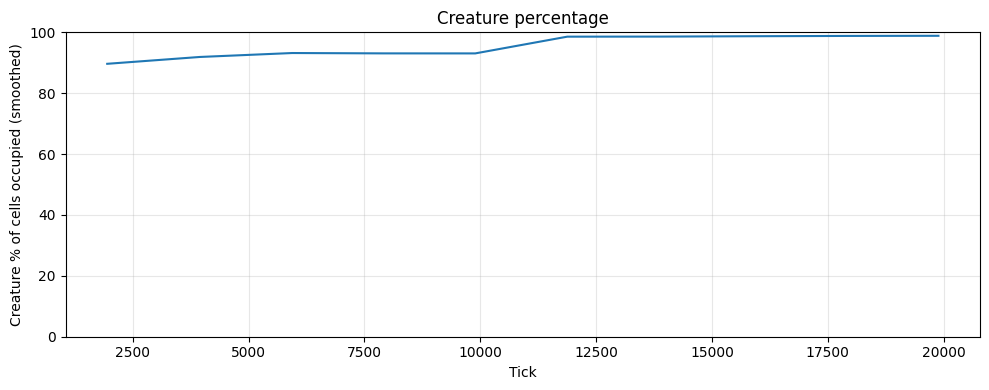

In [70]:
# Plot creature percentage over time (tick on X axis), with a smoothed curve

import matplotlib.pyplot as plt

required_cols = {"creature_count", "colony_width", "colony_height"}
missing = required_cols - set(df.columns)
if missing:
    raise KeyError(
        f"Missing columns {missing} in parquet file. "
        "Regenerate parquet with updated stats_shots_to_parquet.py to include colony_width/colony_height."
    )

# Sort by tick to ensure a sensible time series
plot_df = df.sort_values("tick").copy()

# Compute percentage of grid cells occupied by creatures
plot_df["grid_cells"] = plot_df["colony_width"] * plot_df["colony_height"]
plot_df["creature_pct"] = (plot_df["creature_count"] / plot_df["grid_cells"]) * 100.0

# Compute a rolling mean to smooth the line (adjust window size as desired)
window = 5  # number of points in the smoothing window
plot_df["creature_pct_smooth"] = plot_df["creature_pct"].rolling(window=window, min_periods=1, center=True).mean()

plt.figure(figsize=(10, 4))
plt.plot(
    plot_df["tick"],
    plot_df["creature_pct_smooth"],
    linestyle="-",
    linewidth=1.5,
)
plt.xlabel("Tick")
plt.ylabel("Creature % of cells occupied (smoothed)")
plt.title("Creature percentage")
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



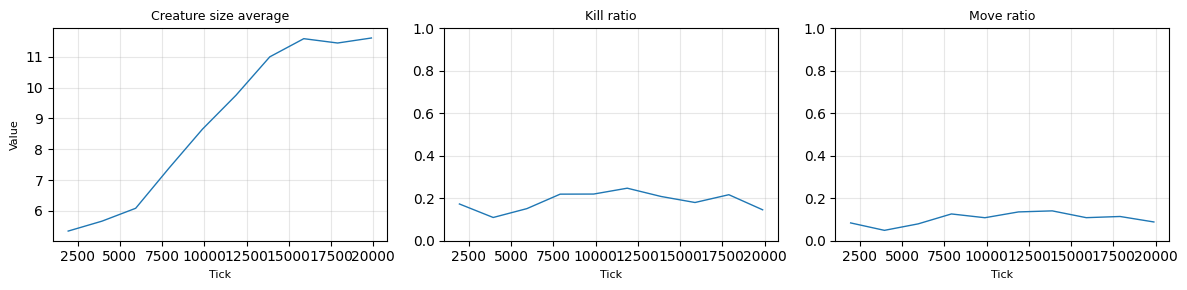

In [71]:
# Compact view: 3 charts horizontally (creature size avg, kill ratio, move ratio)

import matplotlib.pyplot as plt

plot_df = df.sort_values("tick").copy()

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False)

# 1) Numerical gene: creature_size_avg (or creature_size_mean fallback)
y_col_creature = None
if "creature_size_avg" in plot_df.columns:
    y_col_creature = "creature_size_avg"
elif "creature_size_mean" in plot_df.columns:
    y_col_creature = "creature_size_mean"

if y_col_creature is not None:
    window = 5  # smoothing window size
    smooth_col = f"{y_col_creature}_smooth"
    plot_df[smooth_col] = plot_df[y_col_creature].rolling(window=window, min_periods=1, center=True).mean()
    axes[0].plot(plot_df["tick"], plot_df[smooth_col], linewidth=1)
    axes[0].set_title("Creature size average", fontsize=9)
    axes[0].set_xlabel("Tick", fontsize=8)
    axes[0].set_ylabel("Value", fontsize=8)
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, "Creature size average not found", ha="center", va="center", fontsize=8)

# 2) Boolean gene: can_kill_true_fraction
if "can_kill_true_fraction" in plot_df.columns:
    axes[1].plot(plot_df["tick"], plot_df["can_kill_true_fraction"], linewidth=1)
    axes[1].set_title("Kill ratio", fontsize=9)
    axes[1].set_xlabel("Tick", fontsize=8)
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, "Kill ratio not found", ha="center", va="center", fontsize=8)

# 3) Boolean gene: can_move_true_fraction
if "can_move_true_fraction" in plot_df.columns:
    axes[2].plot(plot_df["tick"], plot_df["can_move_true_fraction"], linewidth=1)
    axes[2].set_title("Move ratio", fontsize=9)
    axes[2].set_xlabel("Tick", fontsize=8)
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, "Move ratio not found", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

